In [1]:
! pip install torch torchvision timm Pillow tqdm scikit-learn


Defaulting to user installation because normal site-packages is not writeable


/Users/lemniskata/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Loading samples:   0%|          | 0/4 [00:00<?, ?it/s]

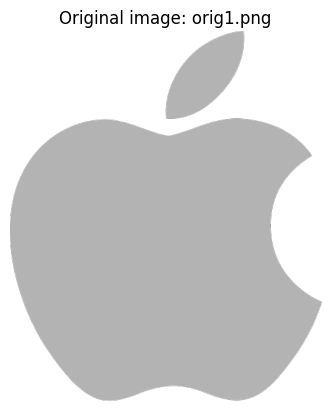

Loading samples:  25%|██▌       | 1/4 [00:00<00:00,  7.00it/s]

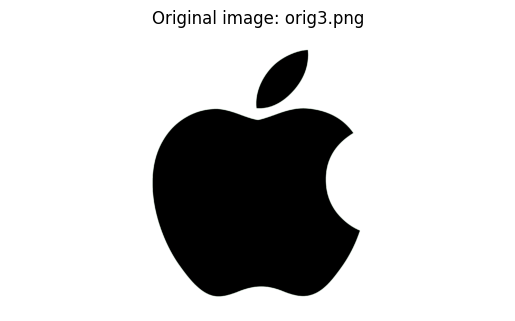

Loading samples:  50%|█████     | 2/4 [00:00<00:00,  3.29it/s]

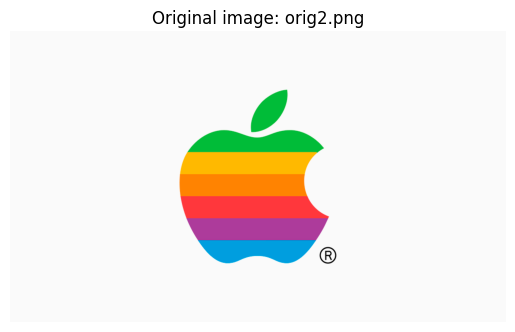

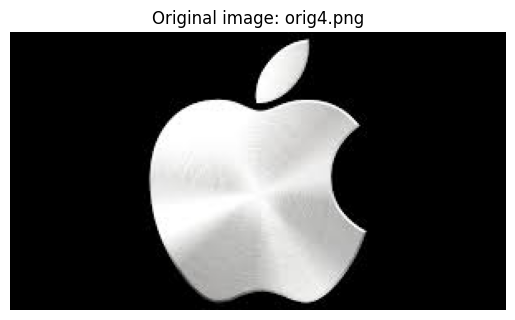

Loading samples: 100%|██████████| 4/4 [00:00<00:00,  5.49it/s]



Testing image: chanel.jpg


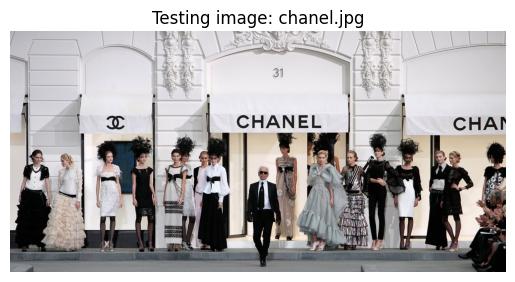

Result: NO
Confidence: 0.5666

Testing image: iphone.jpg


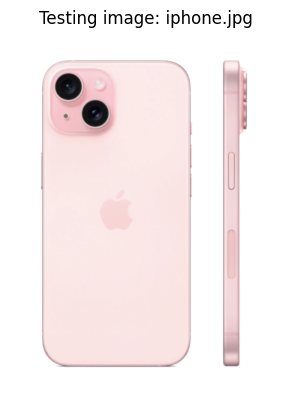

Result: YES
Confidence: 0.6654

Testing image: macbook.jpg


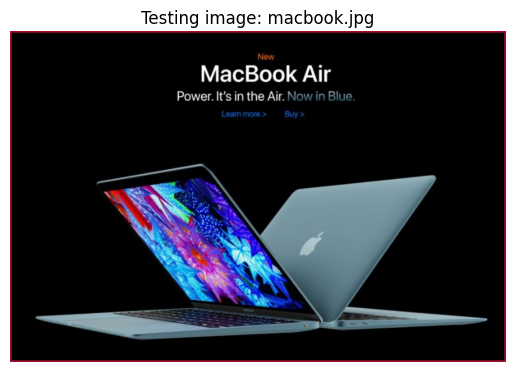

Result: YES
Confidence: 0.6354

Testing image: chanel.png


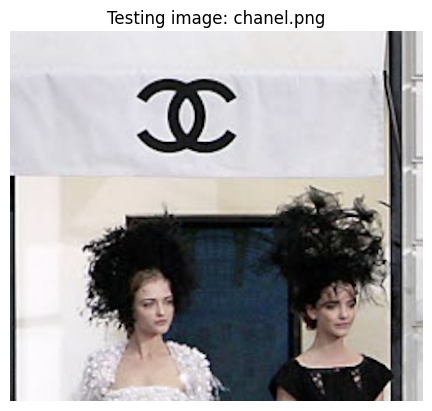

Result: NO
Confidence: 0.5300


In [2]:
import logging
from pathlib import Path
import numpy as np
from PIL import Image
from sklearn.metrics.pairwise import cosine_similarity
import torch
from torchvision import transforms, models
import timm
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")


class LogoMatcherNN:
    def __init__(self, model_name='resnet', device=None):
        self.logger = logging.getLogger("LogoMatcherNN")
        self.device = device if device else ('cuda' if torch.cuda.is_available() else 'cpu')

        # Загрузка модели
        self.model_name = model_name
        self.model = self._load_model()
        self.model = self.model.to(self.device)
        self.model.eval()
        
        # Предобработка изображений
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
        ])
        
        # Установка трешхолда
        self.similarity_threshold = 0.6

    # Загрузка модели и удаление последнего слоя классификации
    def _load_model(self):
        if 'resnet' in self.model_name:
            model = models.resnet50(pretrained=True)
            model.fc = torch.nn.Identity()
        return model

    # Загрузка и предобработка изображений
    def preprocess_image(self, image_path):
        try:
            image = Image.open(image_path).convert('RGB')
            image_tensor = self.transform(image)
            return image_tensor.unsqueeze(0)
        except Exception as e:
            self.logger.error(f"Error processing image {image_path}: {e}")
            return None

    # Получение эмбеддинга изображения
    def get_embedding(self, image_tensor):
        with torch.no_grad():
            embedding = self.model(image_tensor.to(self.device))
            return embedding.cpu().numpy()

    # Обработка образцов логотипов
    def load_logo_samples(self, samples_dir):
        samples_path = Path(samples_dir)
        embeddings = []
        
        self.logger.info("Loading logo samples...")
        for img_path in tqdm(list(samples_path.glob('*.jpg')) + list(samples_path.glob('*.png')), desc="Loading samples"):
            image_tensor = self.preprocess_image(img_path)
            img = Image.open(img_path)
            plt.imshow(img)
            plt.axis('off')
            plt.title(f"Original image: {img_path.name}")
            plt.show()
            if image_tensor is not None:
                embedding = self.get_embedding(image_tensor)
                embeddings.append(embedding)
        
        return np.vstack(embeddings)

    # Сравнение тестового изображения с оригинальными образцами
    def compare_with_samples(self, test_image_path, logo_embeddings):
        # Получение эмбеддинга тестового изображения
        image_tensor = self.preprocess_image(test_image_path)
        if image_tensor is None:
            return {'is_match': False, 'confidence': 0.0}
            
        test_embedding = self.get_embedding(image_tensor)
        
        # Вычисление косинусного сходства
        similarities = cosine_similarity(test_embedding, logo_embeddings)
        max_similarity = np.max(similarities)
        
        result = {
            'is_match': max_similarity > self.similarity_threshold,
            'confidence': float(max_similarity)
        }
        
        self.logger.info(f"Similarity score: {max_similarity:.4f}")
        return result

# Основная функция
def main():
    # Инициализация модели
    matcher = LogoMatcherNN()
    
    # Данные
    samples_dir = "test/logo_samples"
    test_dir = "test/crop_image"
    
    # Загрузка эмбеддингов оригинальных образцов
    logo_embeddings = matcher.load_logo_samples(samples_dir)
    
    # Проверка тестовых изображений
    test_path = Path(test_dir)
    
    for img_path in list(test_path.glob('*.jpg')) + list(test_path.glob('*.png')):
        print(f"\nTesting image: {img_path.name}")
        img = Image.open(img_path)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"Testing image: {img_path.name}")
        plt.show()
    
        result = matcher.compare_with_samples(img_path, logo_embeddings)
        print(f"Result: {'YES' if result['is_match'] else 'NO'}")
        print(f"Confidence: {result['confidence']:.4f}")

if __name__ == "__main__":
    main()
